In [ ]:
!pip install fastavro

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 64.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Note that `output_A.avro` is a smaller file with lesser songs; while `output_A2Z.avro` contains all available songs.

In [ ]:
import fastavro
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

with open('/content/output_A.avro', 'rb') as f:
    records = [r for r in fastavro.reader(f)]

df = pd.DataFrame(records)

df.head(3)

,bars_confidence_mean,bars_confidence_std,bars_confidence_max,beats_confidence_mean,beats_confidence_std,beats_confidence_max,sections_confidence_mean,sections_confidence_std,sections_confidence_max,segments_confidence_mean,...,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_latitude,artist_longitude,artist_playmeid,release_7digitalid,song_hotttnesss,track_7digitalid,year
0,0.117149,0.153265,0.682,0.376149,0.195741,0.801,0.558667,0.298345,1.0,0.402875,...,324573,0.639903,0.461318,NaN,NaN,166043,497103,0.733372,5504670,2009
1,0.121100,0.152361,0.819,0.000000,0.000000,0.000,0.578714,0.316845,1.0,0.400524,...,173942,0.671755,0.386606,37.77916,-122.42005,38879,226813,0.481694,2496043,2005
2,0.172096,0.256234,0.994,0.611462,0.157866,0.858,0.477100,0.304732,1.0,0.696677,...,165270,0.581794,0.401998,NaN,NaN,4479,300848,0.602120,3401791,0


In [ ]:
import fastavro
import pandas as pd
def load_specific_columns(file_path, columns_needed):
    """Load only specific columns from avro file"""
    data = []
    with open('/content/output_A.avro', 'rb') as f:
        avro_reader = fastavro.reader(f)
        for record in avro_reader:
            # Only keep the columns we need
            filtered_record = {col: record[col] for col in columns_needed}
            data.append(filtered_record)
    df = pd.DataFrame(data)
    df = df[(df['year'] != 0) & (df['year'].notna())]
    return df

needed_columns = ['segments_timbre', 'year']

filtered_data = load_specific_columns('/content/output_A.avro', needed_columns)

In [ ]:
filtered_data.head(3)

,segments_timbre,year
0,"[50.99727008547008, 38.26064615384616, 32.4559...",2009
1,"[48.47387990762126, 27.082863741339494, 33.442...",2005
4,"[43.07103636363632, -4.035390909090912, 23.572...",1969


In [ ]:
# Make a clean copy and reset index
filtered_data_clean = filtered_data.reset_index(drop=True)

# Convert arrays to columns
timbre_df = pd.DataFrame(filtered_data_clean['segments_timbre'].tolist(),
                        columns=[f'timbre_{i}' for i in range(90)])

# Combine with year - now using the clean DataFrame
final_df = pd.concat([
    filtered_data_clean['year'].reset_index(drop=True),
    timbre_df.reset_index(drop=True)
], axis=1)

print("Original shape:", filtered_data.shape)
print("Final shape:", final_df.shape)

Original shape: (20097, 2)
Final shape: (20097, 91)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Extract features (X) and target (y)
X = final_df.filter(regex='^timbre_')  # Selects all columns starting with 'timbre_'
y = final_df['year']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (20097, 90)
y shape: (20097,)


In [ ]:
# Standardize features (important for ridge regression)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_scaled

array([[ 1.24853267,  0.70887662,  0.67008541, ..., -0.84066174,
         0.38709982, -0.87475045],
       [ 0.83100142,  0.49167488,  0.69826599, ..., -0.66637371,
        -0.11575817, -1.18846783],
       [-0.06297685, -0.11300132,  0.41635234, ..., -0.15543452,
        -0.84051237, -0.97039821],
       ...,
       [ 0.46056124,  0.64730066,  0.53837463, ..., -0.71712975,
         0.44554674, -0.57781413],
       [-1.1834732 , -0.97024042, -0.19179185, ..., -0.04828663,
        -0.24312759,  0.24748684],
       [-1.02919591, -1.29552811, -0.01472036, ..., -0.71842112,
         0.15612617,  1.8808323 ]])

In [ ]:
# Basic split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42
)

print(f"\nTraining shapes: {X_train.shape}, {y_train.shape}")
print(f"Test shapes: {X_test.shape}, {y_test.shape}")


Training shapes: (16077, 90), (16077,)
Test shapes: (4020, 90), (4020,)


In [ ]:
# For scikit-learn models
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Initialize and train model
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"\nModel MSE: {mse:.2f}")
print(f"Average error: {np.sqrt(mse):.2f} years")


Model MSE: 95.72
Average error: 9.78 years


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Convert data to PyTorch tensors
X_train_t = torch.FloatTensor(X_train).cuda()
y_train_t = torch.FloatTensor(y_train.values if hasattr(y_train, 'values') else y_train).cuda()
X_test_t = torch.FloatTensor(X_test).cuda()

# Create DataLoader for batch processing
train_data = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_data, batch_size=1024, shuffle=True)

# Define model
class LinearRegressionGPU(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

model = LinearRegressionGPU(X_train.shape[1]).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Training loop
for epoch in range(100):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.view(-1, 1))
        loss.backward()
        optimizer.step()

# Evaluation
with torch.no_grad():
    y_pred = model(X_test_t).cpu().numpy()
    torch_mse = mean_squared_error(y_test, y_pred)
print(f"PyTorch GPU MSE: {torch_mse:.1f}")

PyTorch GPU MSE: 95.6


In [ ]:
import torch
import numpy as np

# 1. Setup GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Convert data to PyTorch tensors on GPU
X_t = torch.FloatTensor(X_scaled).to(device)
y_t = torch.FloatTensor(y.values if hasattr(y, 'values') else y).to(device).view(-1, 1)

# 3. Use the paper's best alpha value directly
best_alpha = 0.01  # From the paper's findings

# 4. Center the data (important for regularization)
X_mean = X_t.mean(0, keepdim=True)
y_mean = y_t.mean()
X_centered = X_t - X_mean
y_centered = y_t - y_mean

# 5. Solve ridge regression in closed-form
XTX = X_centered.T @ X_centered
reg_matrix = best_alpha * torch.eye(XTX.shape[0], device=device) * X_centered.shape[0]
weights = torch.linalg.solve(XTX + reg_matrix, X_centered.T @ y_centered)

# 6. Make predictions (add back mean)
with torch.no_grad():
    y_pred = X_centered @ weights + y_mean
    mse = ((y_t - y_pred).pow(2).mean()).item()

# 7. Leave-One-Out Cross-Validation (simplified)
def fast_loocv(X, y, alpha):
    n_samples = X.shape[0]
    H = X @ torch.linalg.solve(X.T @ X + alpha * torch.eye(X.shape[1], device=device) * n_samples, X.T)
    h = torch.diag(H)
    residuals = y - X @ weights
    return (residuals / (1 - h)).pow(2).mean().item()

loocv_mse = fast_loocv(X_centered, y_centered, best_alpha)

print("\nResults using paper's optimal alpha:")
print(f"Alpha (λ) used: {best_alpha}")
print(f"LOO-CV MSE: {loocv_mse:.1f}")
print(f"Training MSE: {mse:.1f}")
print(f"Model weights shape: {weights.shape}")

Using device: cuda

Results using paper's optimal alpha:
Alpha (λ) used: 0.01
LOO-CV MSE: 95.0
Training MSE: 94.0
Model weights shape: torch.Size([90, 1])


Mean Squared Error: 4823.52
Mean Absolute Error: 11.29
R-squared: -38.75


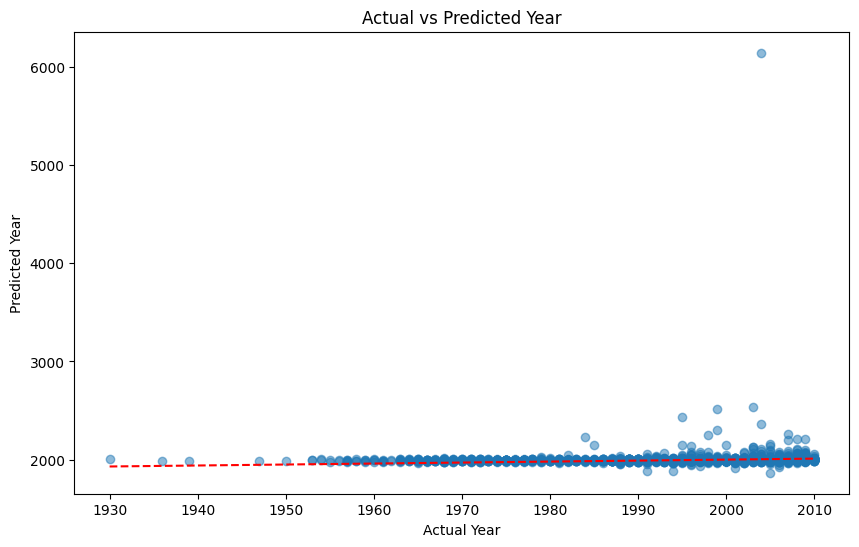

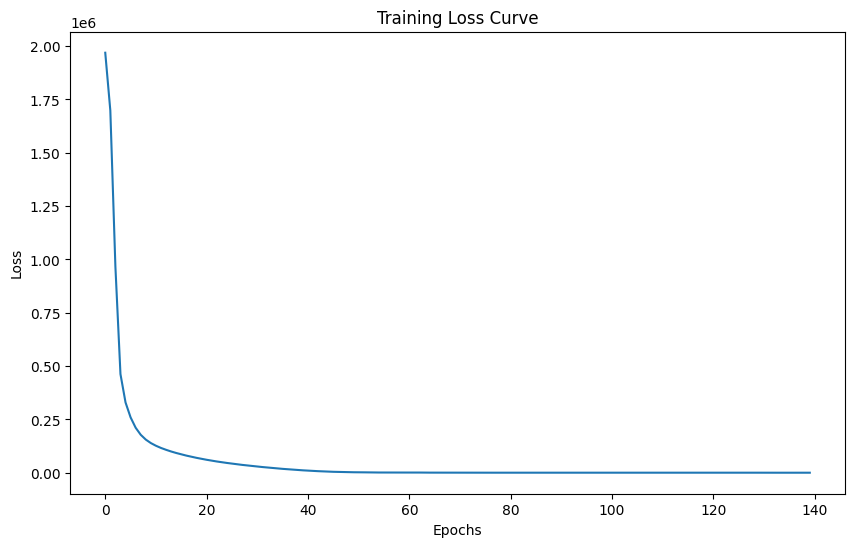

In [ ]:
import fastavro
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def load_specific_columns(file_path, columns_needed):
    """Load only specific columns from avro file"""
    data = []
    with open(file_path, 'rb') as f:
        avro_reader = fastavro.reader(f)
        for record in avro_reader:
            # Only keep the columns we need
            filtered_record = {col: record[col] for col in columns_needed}
            data.append(filtered_record)
    df = pd.DataFrame(data)
    df = df[(df['year'] != 0) & (df['year'].notna())]
    return df

# Load the data
needed_columns = ['segments_timbre', 'year']
filtered_data = load_specific_columns('/content/output_A.avro', needed_columns)

# Prepare the features and target
timbre_features = pd.DataFrame(filtered_data['segments_timbre'].tolist(),
                             columns=[f'timbre_{i}' for i in range(90)])
years = filtered_data['year']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    timbre_features, years, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the MLP model
mlp = MLPRegressor(
    hidden_layer_sizes=(100, 50),  # Two hidden layers with 100 and 50 neurons
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)

mlp.fit(X_train_scaled, y_train)

# Make predictions
y_pred = mlp.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R-squared: {r2:.2f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
plt.xlabel('Actual Year')
plt.ylabel('Predicted Year')
plt.title('Actual vs Predicted Year')
plt.show()

# Plot training loss curve
plt.figure(figsize=(10, 6))
plt.plot(mlp.loss_curve_)
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Classification Report:
              precision    recall  f1-score   support

   1950-1970       0.11      0.01      0.03       135
   1970-1990       0.45      0.37      0.40       560
   1990-2000       0.46      0.29      0.36      1078
   2000-2010       0.69      0.88      0.78      2239
       <1950       0.00      0.00      0.00         8

    accuracy                           0.62      4020
   macro avg       0.34      0.31      0.31      4020
weighted avg       0.58      0.62      0.59      4020


Accuracy: 0.6223880597014926


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


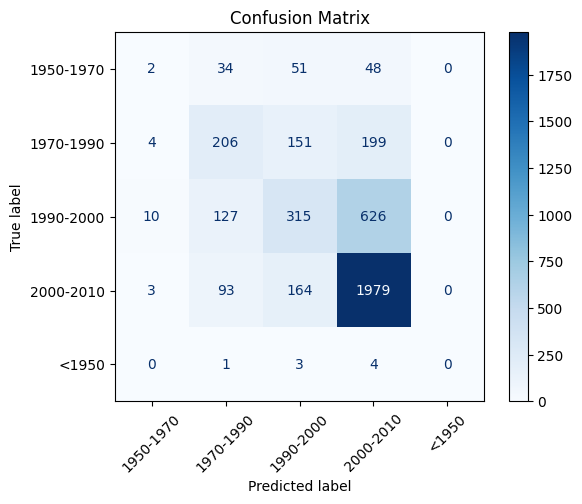

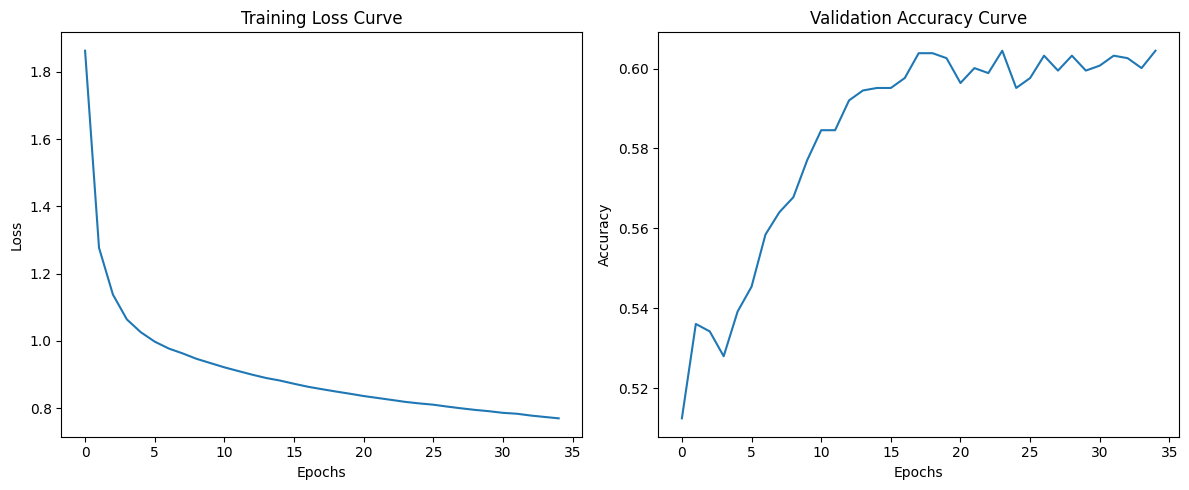

In [ ]:
import fastavro
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                            confusion_matrix, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt

def load_specific_columns(file_path, columns_needed):
    """Load only specific columns from avro file"""
    data = []
    with open(file_path, 'rb') as f:
        avro_reader = fastavro.reader(f)
        for record in avro_reader:
            filtered_record = {col: record[col] for col in columns_needed}
            data.append(filtered_record)
    df = pd.DataFrame(data)
    df = df[(df['year'] != 0) & (df['year'].notna())]
    return df

# Load the data
needed_columns = ['segments_timbre', 'year']
filtered_data = load_specific_columns('/content/output_A.avro', needed_columns)

# Convert year to classes (adjust bins as needed)
year_bins = [1900, 1950, 1970, 1990, 2000, 2010, 2020]
year_labels = ['<1950', '1950-1970', '1970-1990', '1990-2000', '2000-2010', '>2010']
filtered_data['year_class'] = pd.cut(filtered_data['year'], bins=year_bins, labels=year_labels)

# Remove any empty classes that might have been created
existing_classes = filtered_data['year_class'].dropna().unique()
filtered_data = filtered_data[filtered_data['year_class'].isin(existing_classes)]

# Prepare features and target
timbre_features = pd.DataFrame(filtered_data['segments_timbre'].tolist(),
                             columns=[f'timbre_{i}' for i in range(90)])
classes = filtered_data['year_class']

# Encode class labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(classes)

# Get the actual class names present in the data
actual_class_names = label_encoder.classes_

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    timbre_features, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train MLP classifier
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),  # Two hidden layers
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    batch_size=2048,
    learning_rate='adaptive'
)

mlp.fit(X_train_scaled, y_train)

# Make predictions
y_pred = mlp.predict(X_test_scaled)

# Convert encoded labels back to original class names for reporting
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Evaluate model
print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels, target_names=actual_class_names))

print("\nAccuracy:", accuracy_score(y_test_labels, y_pred_labels))

# Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=actual_class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=actual_class_names)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.show()

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(mlp.loss_curve_)
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(mlp.validation_scores_)
plt.title('Validation Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()